In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate
        self.l2_m = 0
        self.l1_m = 0
        self.l2_v = 0
        self.l1_v = 0
        self.t = 0
        
        # Weights Initilization
        self.w0 = np.random.normal(0.0, 0.1, (self.input_nodes, self.hidden_nodes))
        self.w1 = np.random.normal(0.0, 0.1, (self.hidden_nodes, self.output_nodes))
        
        def sigmoid(x, deriv=False):
            
            if deriv:
                return x*(1-x)
            return 1/(1+np.exp(-x))
        
        self.activation_function = sigmoid
        
    def train(self, features, targets, decay_rate_1 = None, 
              decay_rate_2 = None, epsilon = None):
        # Feed Forward
        l0 = features
        l1 = self.activation_function(np.dot(l0, self.w0))
        l2 = self.activation_function(np.dot(l1, self.w1))
        
        # Backpropagation
        l2_error = l2 - targets
        l2_delta = l2_error * self.activation_function(l2, deriv=True)
        l1_error = l2_delta.dot(self.w1.T)
        l1_delta = l1_error * self.activation_function(l1, deriv=True)                  

        # Gradients for each layer
        g1 = l1.T.dot(l2_delta)
        g0 = l0.T.dot(l1_delta)

        self.t += 1 # Increment Time Step

        # Computing 1st and 2nd moment for each layer
        self.l2_m = self.l2_m * decay_rate_1 + (1- decay_rate_1) * g1
        self.l1_m = self.l1_m * decay_rate_1 + (1- decay_rate_1) * g0

        self.l2_v = self.l2_v * decay_rate_2 + (1- decay_rate_2) * (g1 ** 2)
        self.l1_v = self.l1_v * decay_rate_2 + (1- decay_rate_2) * (g0 ** 2)

        l2_m_corrected = self.l2_m / (1-(decay_rate_1 ** self.t))
        l2_v_corrected = self.l2_v / (1-(decay_rate_2 ** self.t))

        # Computing bias-corrected moment
        l1_m_corrected = self.l1_m / (1-(decay_rate_1 ** self.t))
        l1_v_corrected = self.l1_v / (1-(decay_rate_2 ** self.t))

        # Update Weights
        w1_update = l2_m_corrected / (np.sqrt(l2_v_corrected) + epsilon)
        w0_update = l1_m_corrected / (np.sqrt(l1_v_corrected) + epsilon)

        self.w1 -= (self.lr * w1_update)
        self.w0 -= (self.lr * w0_update)
            
    def run(self, features):
        l0 = features
        l1 = self.activation_function(np.dot(l0, self.w0))
        l2 = self.activation_function(np.dot(l1, self.w1))        
        return pd.DataFrame(l2)

In [68]:
def MSE(y, Y):
    return np.mean((y.values - Y.values) ** 2)

In [83]:
# Procedure that returns accuracy of network
def test_model(network):
    test_predictions = network.run(X_test)
    correct = 0
    total = 0
    for i in range(len(test_predictions)):
        total += 1
        if test_predictions.iloc[i].idxmax(axis=1) == int(y_test.iloc[i].idxmax(axis=1)[-1]):
            correct += 1
    return correct/total

In [108]:
import time

def build_network(network, epochs, evaluation=False):
    losses = {'train':[], 'validation':[]} # For Plotting of MSE
    accuracy = []

    start = time.time()
        
    # Iterating Over Epochs
    for i in range(epochs):
        
        network.train(X_train, 
                      y_train,
                      decay_rate_1 = 0.9,
                      decay_rate_2 = 0.99,
                      epsilon = 10e-8)
        
        if evaluation == True:
            train_loss = MSE(network.run(X_train), y_train)
            val_loss = MSE(network.run(X_val), y_val)
            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)
            accuracy.append(test_model(network))
        if (i % 20 == 0):
            print(f'Epoch {i}. Time elapsed: {(time.time()-start):.2f}s.')
        
    print('Total time elapsed:{0:.4f}s'.format(time.time()-start))
    return losses, accuracy

In [85]:
# Loading data
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

In [86]:
# Network meta parameters
epochs = 200
learning_rate = 0.01
hidden_nodes = 100
output_nodes = 10
batch_size = 64

In [110]:
my_net = NeuralNetwork(X_train.shape[1], hidden_nodes, output_nodes, learning_rate)

losses, accuracy = build_network(my_net, epochs, evaluation=True)

/home/andrei/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


Epoch 0. Time elapsed: 4.42s.
Epoch 20. Time elapsed: 95.37s.
Epoch 40. Time elapsed: 177.92s.
Epoch 60. Time elapsed: 265.77s.
Epoch 80. Time elapsed: 354.41s.
Epoch 100. Time elapsed: 439.19s.
Epoch 120. Time elapsed: 520.96s.
Epoch 140. Time elapsed: 605.38s.
Epoch 160. Time elapsed: 686.31s.
Epoch 180. Time elapsed: 768.90s.
Total time elapsed:854.3471s


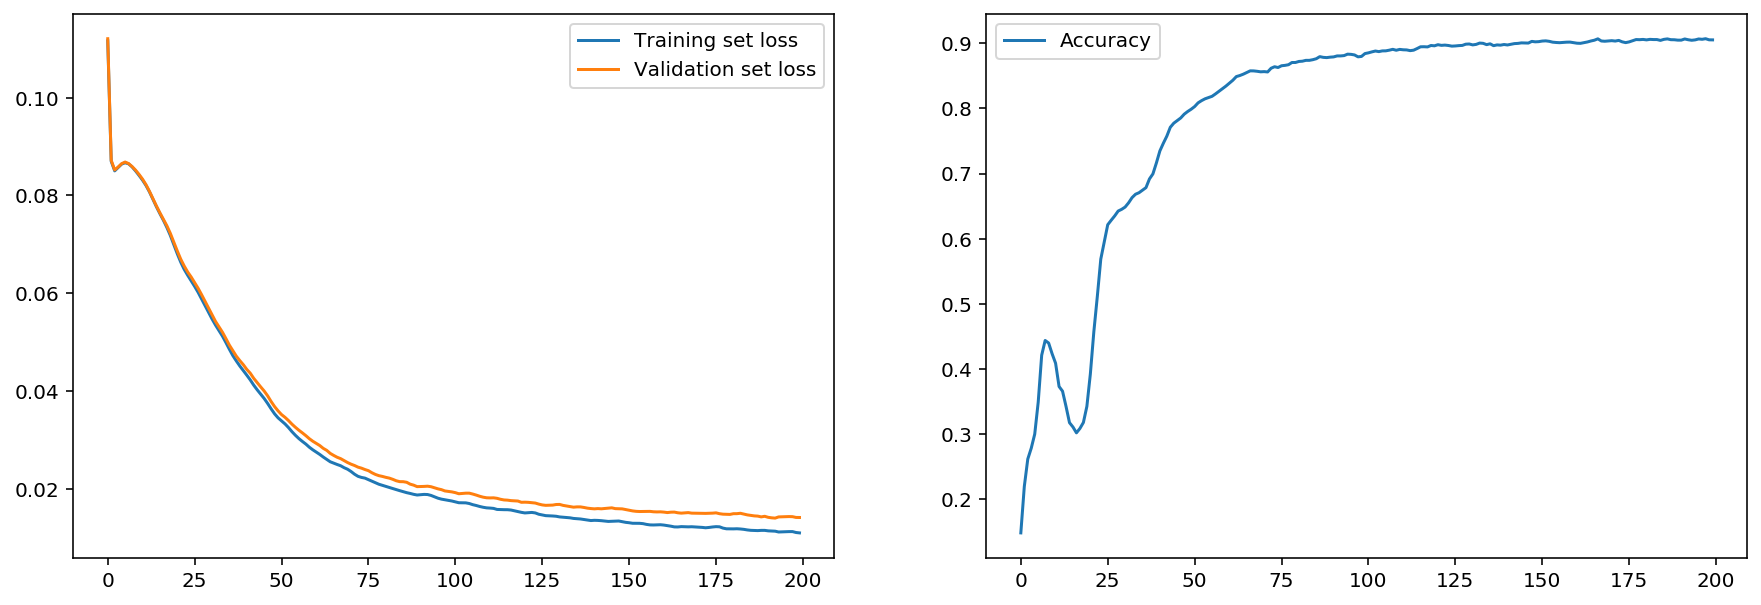

In [111]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(losses_adam['train'], label='Training set loss')
ax1.plot(losses_adam['validation'], label='Validation set loss')
ax1.legend()

ax2.plot(accuracy, label='Accuracy')
ax2.legend()